Previously, we tried 3 models (simple image processing, u-net and u-net extended). We are now going to do a post-processing of Extented U-NET masks and the simple processing.

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import cv2

from keras.models import load_model
import numpy as np
import pickle

from sklearn.model_selection import train_test_split

from skimage.morphology import label
from itertools import groupby
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

Using TensorFlow backend.


In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def prepare_image_final(image):
    if not is_back_and_white(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=50)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if gray.mean() > 150:
            gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=0)
    return gray

def is_back_and_white(image):
    a = np.array_equiv(image[:, :, 0], image[:, :, 1])
    b = np.array_equiv(image[:, :, 1], image[:, :, 2])
    return (a and b)

def boost_contrast(img):
    mini = img.min()
    maxi = img.max()
    return (img-mini)*(255/(maxi-mini))

def add_seuillage(img, level=100):
    img = (img-level)*(255/(255-(2*level)))
    img = np.clip(img, 0, 255)
    return img

def img_to_rle(img):
    result = []
    X = img.flatten('F').tolist()
    current_index = 1
    for k, g in groupby(X):
        l = len(list(g))
        if k > 0.5:
            result.append(current_index)
            result.append(l)
        current_index += l
    return result

"""
From Kaggle but I prefer groupby vs loop
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
"""

def prob_to_rles(x, cutoff=0.5):
    # From Kaggle
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        #yield rle_encoding(lab_img == i)
        yield img_to_rle(lab_img == i)

# Model 1

First, let's prepare a submission dataset with threshold method. As there is a lot a noise on this model, we won't spend a lot of time preparing it. 

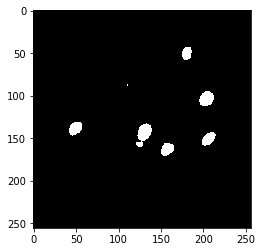

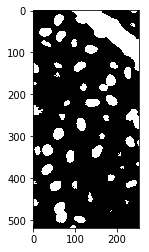

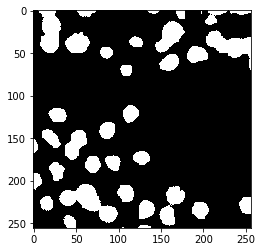

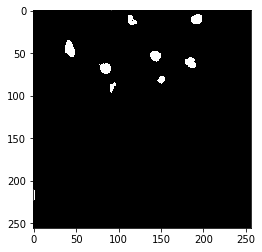

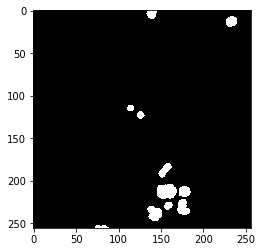

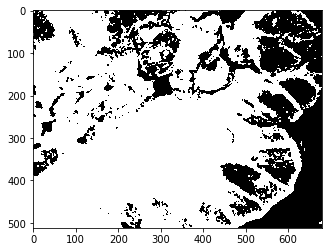

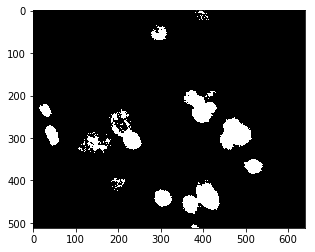

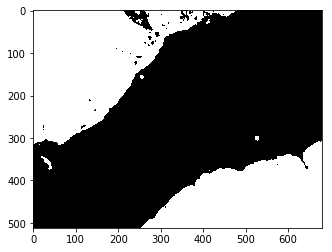

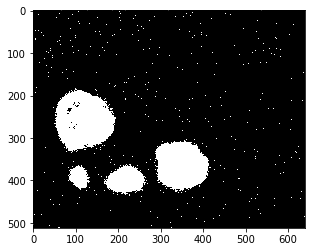

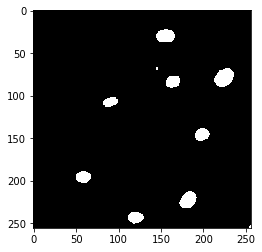

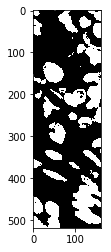

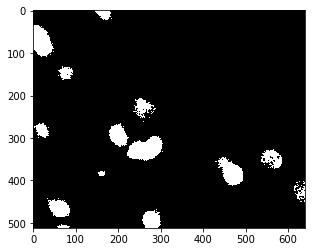

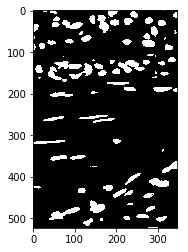

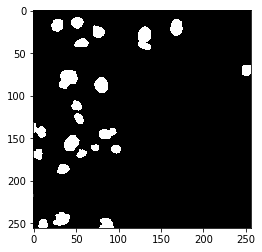

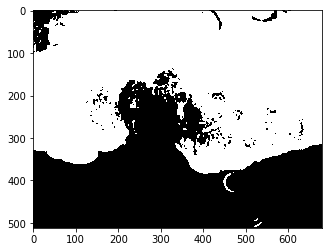

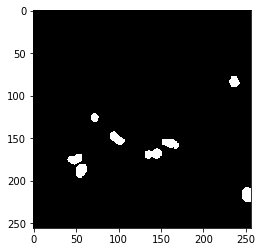

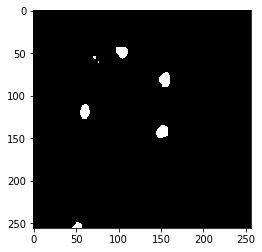

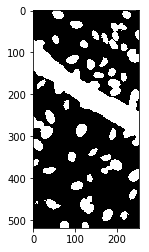

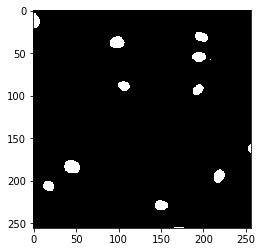

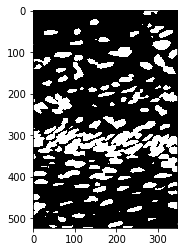

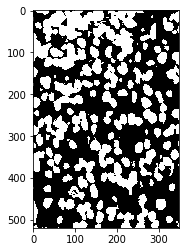

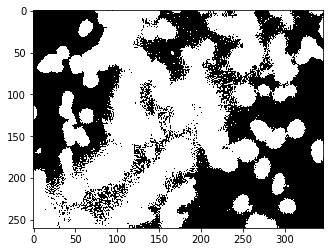

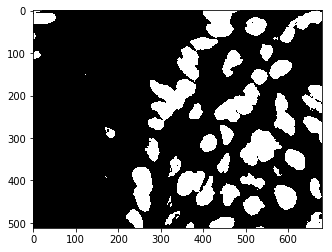

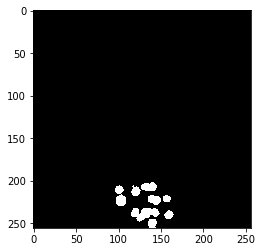

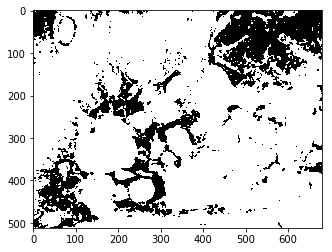

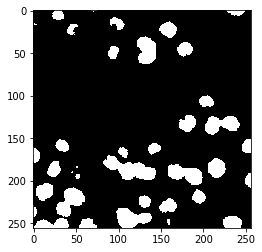

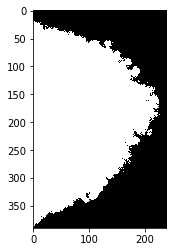

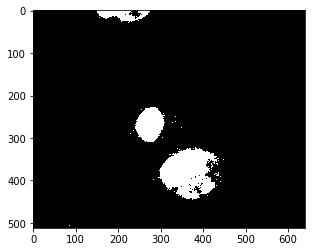

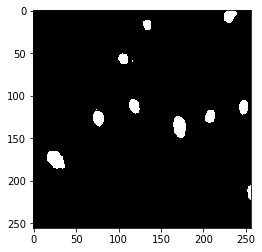

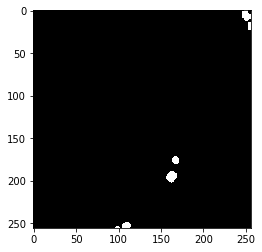

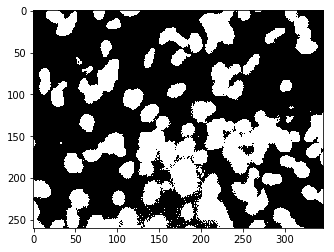

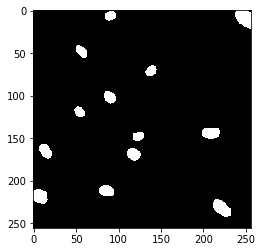

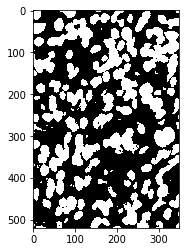

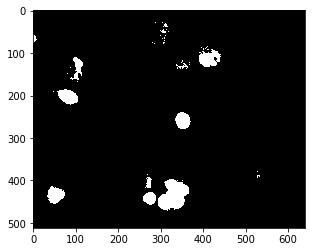

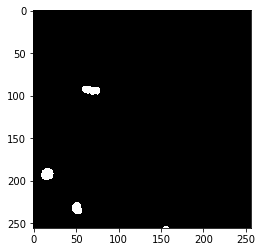

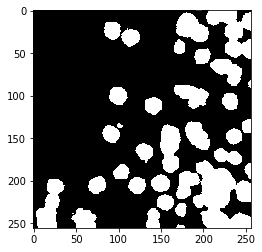

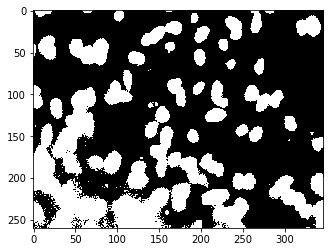

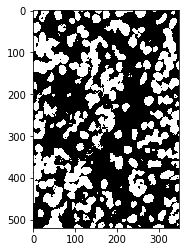

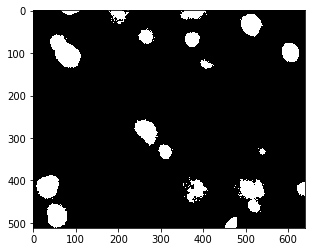

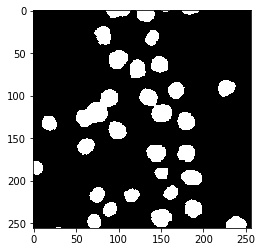

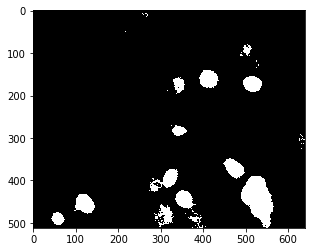

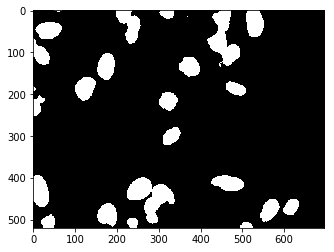

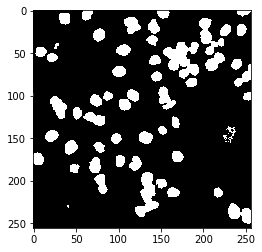

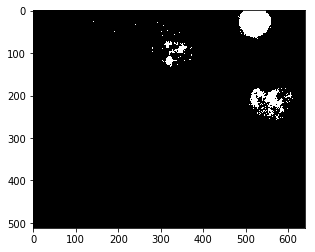

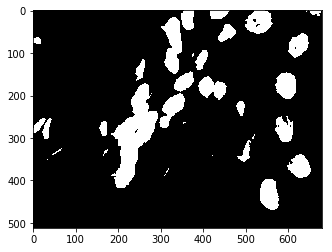

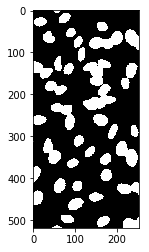

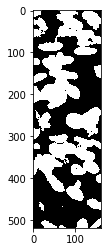

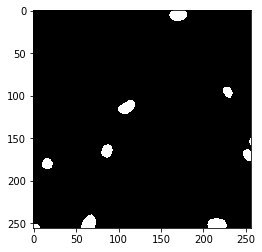

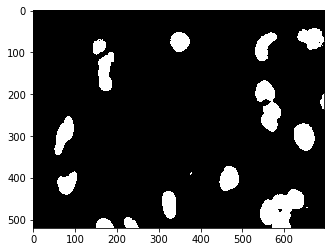

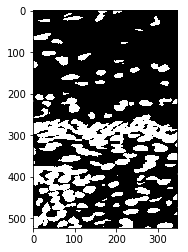

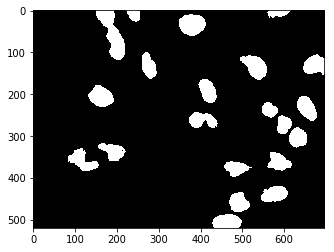

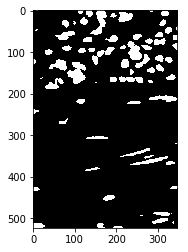

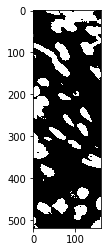

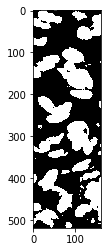

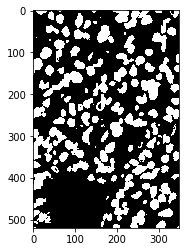

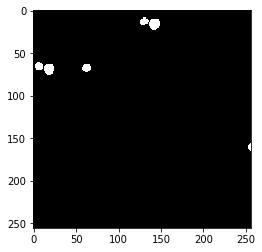

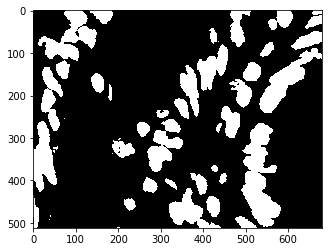

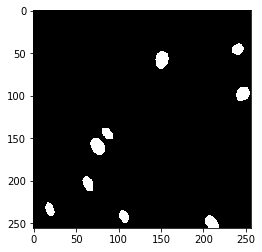

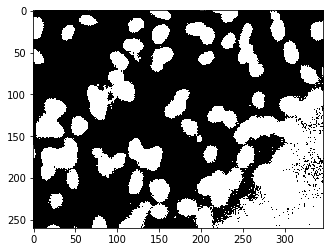

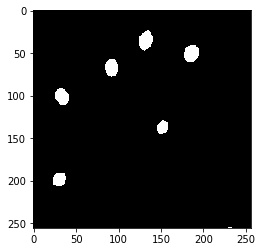

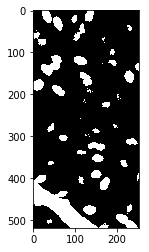

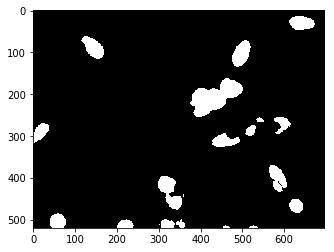

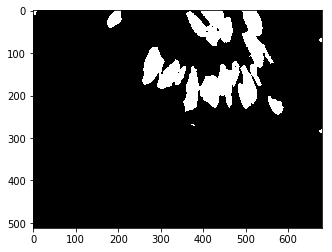

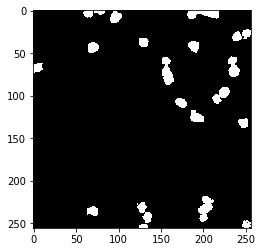

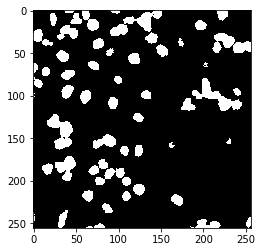

In [4]:
img_list = []
rle_list = []
for img in glob.glob("images/test/*/images/*.png"):
    img_name = os.path.basename(img)[:-4]
    image = cv2.imread(img)
    gray = prepare_image_final(image)
    ret1,th1 = cv2.threshold(gray, 40, 1, cv2.THRESH_BINARY)
    
    for rle in prob_to_rles(th1):
        img_list.append(img_name)
        rle_list.append(rle)

In [ ]:
df = pd.DataFrame()
df['ImageId'] = img_list
df['EncodedPixels'] = pd.Series(rle_list).apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('sub-simple_model.csv', index=False)

With this model, the current score is 0.248 on the kaggle dataset. Now we will focus on the CNN

# Model 2

Let's first load the model and check some images from the test dataset

In [3]:
model = load_model("models/model_extended.h5")

In [4]:
def pre_process_image(img):
    # generation of all 3 image inputs
    X3 = img
    X1 = prepare_image_final(X3)
    X2 = cv2.adaptiveThreshold(X1.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        
    # resize to 256 x 256 for prediction
    X1 = cv2.resize(X1, (256, 256))
    X2 = cv2.resize(X2, (256, 256))
    X3 = cv2.resize(X3, (256, 256))
    
    # transforamtion to proper type/shape
    X1 = np.expand_dims(X1, 3)
    X2 = np.expand_dims(X2, 3)
    X1 = np.expand_dims(X1, 0).astype(np.float32)
    X2 = np.expand_dims(X2, 0).astype(np.float32)
    X3 = np.expand_dims(X3, 0).astype(np.float32)
    
    # normalize
    X1 /= 255.
    X2 /= 255.
    X3 /= 255.
    
    return [X1, X2, X3]

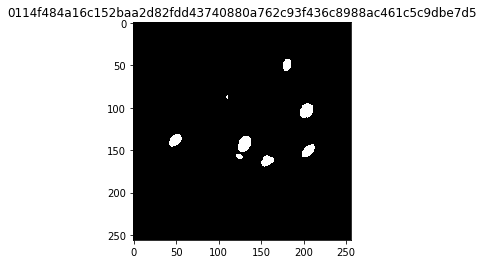

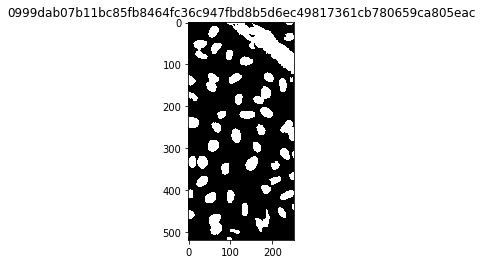

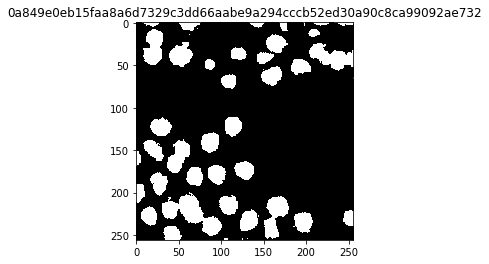

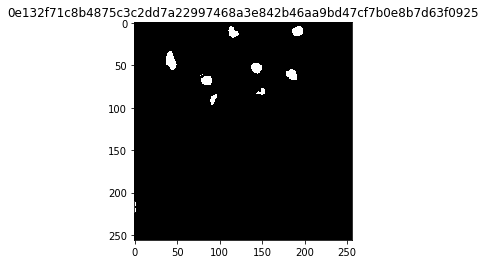

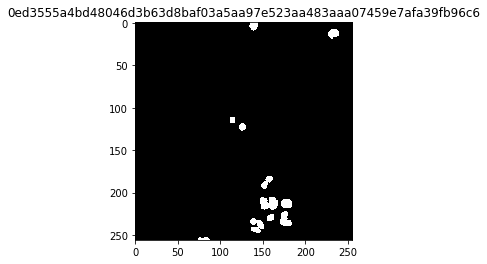

In [5]:
for img in glob.glob("images/test/*/images/*.png")[:5]:
    img_name = os.path.basename(img)[:-4]
    img = cv2.imread(img)
    
    # saving dimensions for later
    W, H = img.shape[:-1]
    
    # pre-process to 3-input images
    X = pre_process_image(img)
    
    # predict
    y = model.predict(X)
    
    # filter with the trigger determined previously
    y = (y>0.4).astype(np.uint8)
    
    # resize to previous shape
    y = cv2.resize(y[0, :, :, 0], (H, W))
    
    plt.imshow(y, cmap="gray")
    plt.title(img_name)
    plt.show()

As it is now, we have overlapping mask and a bit of noise. What we can do is filter the noise and use <a href="https://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html">this tutorial</a> to thy decompose touching cells. As a baseline, we will use the prediciton number 3 above chich have noise and cells with contact

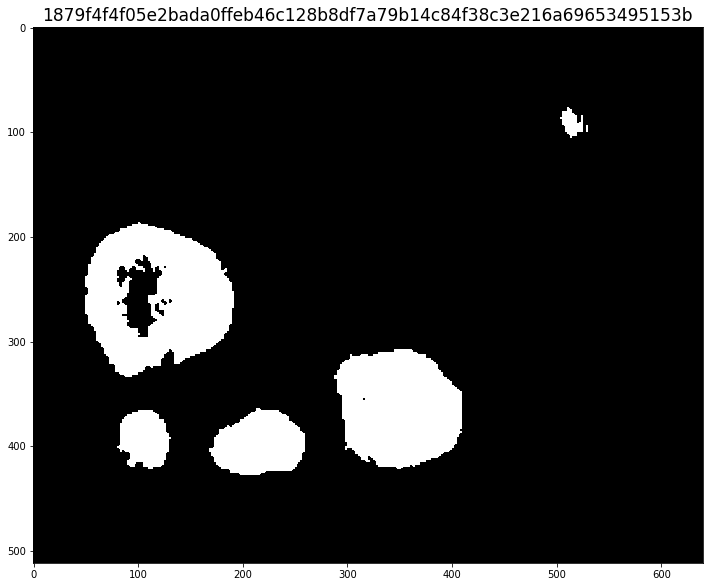

In [260]:
#path = "images/test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/images/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png"
#img_name = "0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732"

path = "images/test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/images/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b.png"
img_name = "1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b"

img = cv2.imread(path)
W, H = img.shape[:-1]
X = pre_process_image(img)
y = model.predict(X)
y = (y>0.4).astype(np.uint8)
y = cv2.resize(y[0, :, :, 0], (H, W))



plt.figure(figsize=(12,12))
plt.imshow(y, cmap="gray")
plt.title(img_name, fontsize=17)
plt.show()

In [130]:
def show(img, cmap="gray"):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap=cmap)
    plt.show()

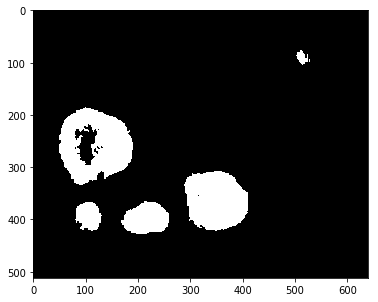

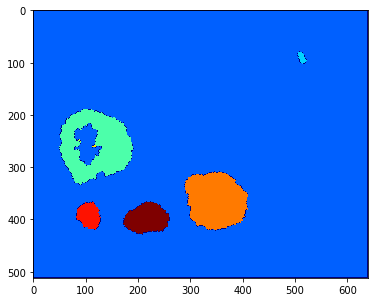

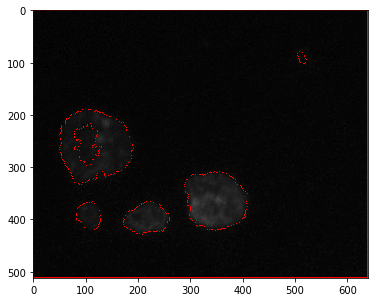

In [261]:
img = cv2.imread(path)

show(y)

# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(y, cv2.MORPH_OPEN, kernel, iterations=2)
opening = opening*255
# show(opening)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=1)
# show(sure_bg)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_C, cv2.DIST_MASK_PRECISE)
# show(dist_transform)

ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
# show(sure_fg)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
# show(unknown)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
# show(markers, "jet")

# 
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]
show(markers, "jet")
# show(img)

# result = markers * y
# show(result, "jet")
show(img)

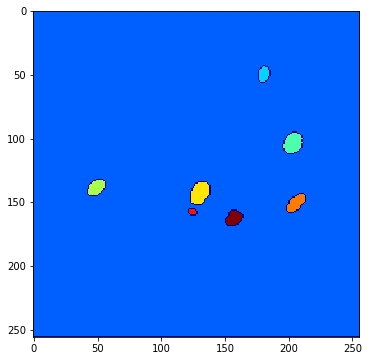

[-1  1  2  3  4  5  6  7  8]
0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


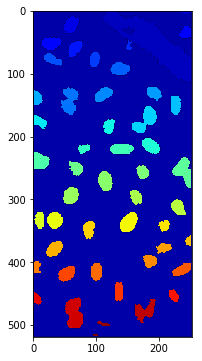

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49 50 51
 52 53]
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


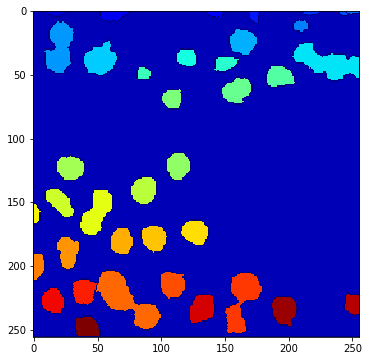

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732


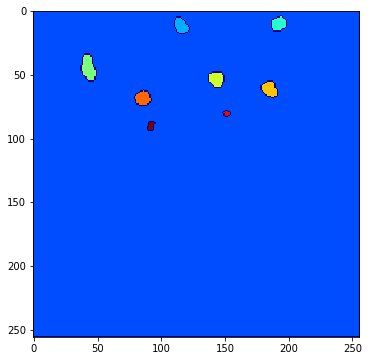

[-1  1  2  3  4  5  6  7  8  9]
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925


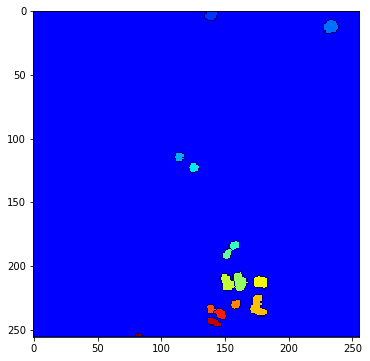

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6


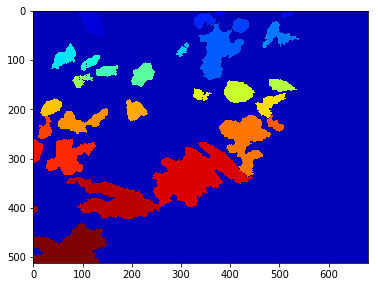

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466


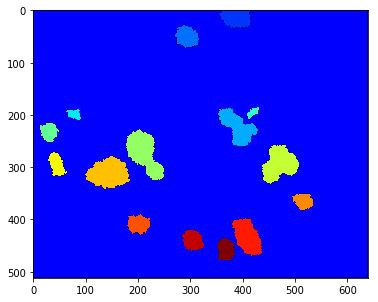

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c


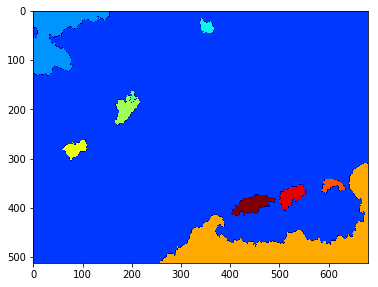

[-1  1  2  3  4  5  6  7  8  9 10]
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


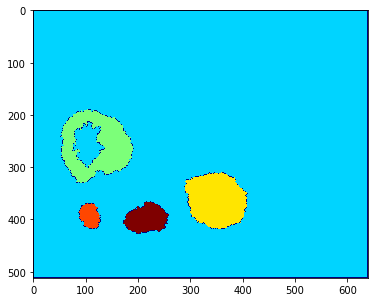

[-1  1  2  3  4  5]
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b


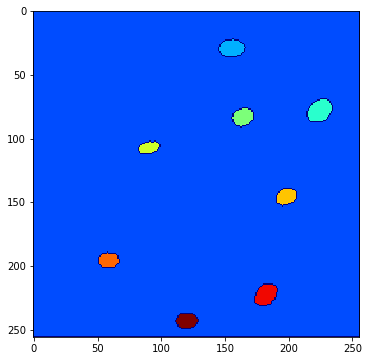

[-1  1  2  3  4  5  6  7  8  9]
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829


In [259]:
img_list = []
rle_list = []
kernel = np.ones((3,3), np.uint8)
    
for img in glob.glob("images/test/*/images/*.png")[:10]:
    img_name = os.path.basename(img)[:-4]
    img = cv2.imread(img)
    W, H, L = img.shape
    X = pre_process_image(img)
    y = model.predict(X)
    y = (y>0.4).astype(np.uint8)
    y = cv2.resize(y[0, :, :, 0], (H, W))
    
    opening = cv2.morphologyEx(y, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = opening*255
    
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_C, cv2.DIST_MASK_PRECISE)
    ret, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img, markers)
#     img[markers == -1] = [255,0,0]
#     show(img)
    show(markers, "jet")
    print(np.unique(markers))
    print(img_name)
    max_cells = markers.max()
    for i in range(2, max_cells+1):
        mask = (markers==i).astype(np.uint8)
        rle = img_to_rle(mask)
        img_list.append(img_name)
        rle_list.append(rle)

In [218]:
df = pd.DataFrame()
df['ImageId'] = img_list
df['EncodedPixels'] = pd.Series(rle_list).apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('sub-cnn_model_extended.csv', index=False)